<a href="https://colab.research.google.com/github/KyleFranzR/CPE-313/blob/main/Rodriguez_Hands-on-Activity-4.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using PyTorch

In [1]:
!nvidia-smi

Thu Feb 19 05:50:51 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Important Libraries

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [12]:
!rm -R /content/hymenoptera_data/train/.ipynb_checkpoints
!ls /content/hymenoptera_data/test/train -a   #to make sure that the deletion has occurred

!rm -R /content/hymenoptera_data/val/.ipynb_checkpoints
!ls /content/hymenoptera_data/val -a   #to make sure that the deletion has occurred

ls: cannot access '/content/drive/MyDrive/CPE-3rd-Year-2nd-Sem/CPE313/Dataset/hymenoptera_data/hymenoptera_data/train': No such file or directory
ls: cannot access '/content/drive/MyDrive/CPE-3rd-Year-2nd-Sem/CPE313/Dataset/hymenoptera_data/hymenoptera_data/val': No such file or directory


In [19]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/CPE-3rd-Year-2nd-Sem/CPE313/Dataset/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


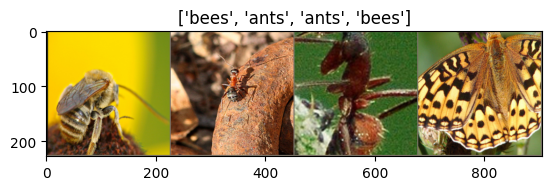

In [20]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [63]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [23]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


## Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5061 Acc: 0.7459
val Loss: 0.2130 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5215 Acc: 0.7746
val Loss: 0.2759 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4955 Acc: 0.8156
val Loss: 0.2814 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4236 Acc: 0.8238
val Loss: 0.2721 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5086 Acc: 0.8197
val Loss: 0.3226 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4747 Acc: 0.8033
val Loss: 0.3503 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3670 Acc: 0.8811
val Loss: 0.2732 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3062 Acc: 0.8730
val Loss: 0.2765 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3809 Acc: 0.8730
val Loss: 0.3002 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3282 Acc: 0.8770
val Loss: 0.2515 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3693 Acc: 0.8607
val Loss: 0.2560 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2906 Acc: 0.8730
val Loss: 0.2613 Acc: 0.9216

Ep

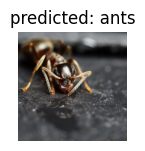

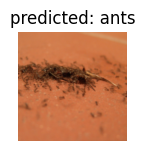

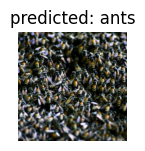

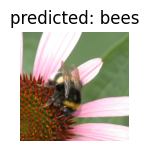

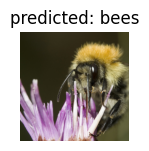

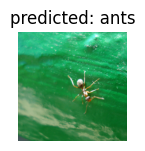

In [25]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [26]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6580 Acc: 0.6066
val Loss: 0.2511 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4603 Acc: 0.8074
val Loss: 0.2971 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4437 Acc: 0.8074
val Loss: 0.3417 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.6409 Acc: 0.7377
val Loss: 0.3340 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4932 Acc: 0.7664
val Loss: 0.3375 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.6184 Acc: 0.7664
val Loss: 0.2533 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4710 Acc: 0.7992
val Loss: 0.2003 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3799 Acc: 0.8279
val Loss: 0.1995 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2719 Acc: 0.9016
val Loss: 0.1912 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3317 Acc: 0.8648
val Loss: 0.1948 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3728 Acc: 0.8279
val Loss: 0.2053 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4125 Acc: 0.7951
val Loss: 0.2270 Acc: 0.9346

Ep

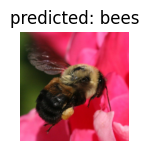

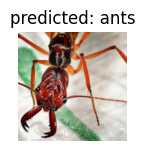

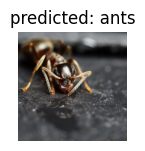

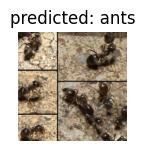

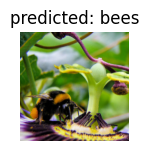

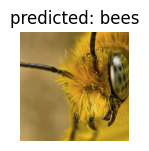

In [28]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [29]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

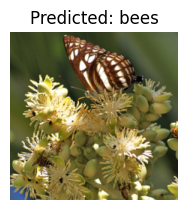

In [31]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/CPE-3rd-Year-2nd-Sem/CPE313/Dataset/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout the
* [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).


# Supplementary Activity

In a new notebook, perform the following:
1. Choose a pretrained model.
2. Finetune on your dataset from the previous activity.
3. Evaluate the performance of the previous model to this finetuned model.

4. Utilize the pretrained ConvNet model as fixed feature extractor.
5. Evaluate the performance of the previous model to this finetuned model.

6.  Discuss the following:
  * How did finetuning affect your performance?
  * Which of the different situations for rule of thumb were applicable to you?

### 1. Choose a pretrained model.

In [66]:
# I will choose DenseNet architecture with imagenet1k weights
from torchvision.models import densenet201

pre_model = densenet201(weights='IMAGENET1K_V1')

### 2. Finetune on your dataset from the previous activity.

In [67]:
n_features = pre_model.classifier.in_features
pre_model.classifier = nn.Linear(n_features, 2)
pre_model = pre_model.to(device)

In [68]:
measure = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre_model.parameters(), lr=0.00001)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [69]:
pre_model = train_model(pre_model, measure, optimizer, lr_sched, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6814 Acc: 0.5492
val Loss: 0.5733 Acc: 0.7582

Epoch 1/24
----------
train Loss: 0.5365 Acc: 0.7828
val Loss: 0.4282 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4831 Acc: 0.8033
val Loss: 0.3646 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4120 Acc: 0.8484
val Loss: 0.3048 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3358 Acc: 0.8934
val Loss: 0.2509 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3076 Acc: 0.8934
val Loss: 0.2164 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3645 Acc: 0.8566
val Loss: 0.2275 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3146 Acc: 0.8689
val Loss: 0.2113 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3108 Acc: 0.8607
val Loss: 0.2072 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2886 Acc: 0.9057
val Loss: 0.2164 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3143 Acc: 0.8934
val Loss: 0.2162 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2788 Acc: 0.8934
val Loss: 0.2022 Acc: 0.9608

Epoch 12/24
----------
t

### 3. Evaluate the performance of the previous model to this finetuned model.

> The previous model finished after 2 minutes and has an accuracy of 0.9411. Meanwhile, the model I used finished after 5 minutes and achieved an accuracy of 0.9673. This may not be a fair comparison because I changed the learning rate and the optimizer, but I can say that it performed better than the former since, although has more training time, it achieved higher accuracy.

### 4. Utilize the pretrained ConvNet model as fixed feature extractor.

In [70]:
conv_model = densenet201(weights='IMAGENET1K_V1')
for param in conv_model.parameters():
  param.requires_grad = False

In [71]:
n_features = conv_model.classifier.in_features
conv_model.classifier = nn.Linear(n_features, 2)
conv_model = conv_model.to(device)

In [75]:
measure = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_model.classifier.parameters(), lr=0.0001)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [76]:
conv_model = train_model(conv_model, measure, optimizer, lr_sched, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6312 Acc: 0.7090
val Loss: 0.5653 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5990 Acc: 0.7254
val Loss: 0.5065 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.5670 Acc: 0.7623
val Loss: 0.4633 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5189 Acc: 0.7746
val Loss: 0.4326 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4866 Acc: 0.8443
val Loss: 0.3760 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4786 Acc: 0.8156
val Loss: 0.3647 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5012 Acc: 0.7951
val Loss: 0.3294 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4874 Acc: 0.7992
val Loss: 0.3319 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4654 Acc: 0.8279
val Loss: 0.3359 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4413 Acc: 0.8484
val Loss: 0.3395 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4690 Acc: 0.8361
val Loss: 0.3389 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4383 Acc: 0.8279
val Loss: 0.3186 Acc: 0.9412

Ep

### 5. Evaluate the performance of the previous model to this finetuned model.
> This new model achieved accuracies 0.967320 and 0.954248, whereas the highest accuracy of the previous model achieved 0.954248. Because of this, I can say that this new model has performed better than the former, although I made some adjustments in the training such as the learning rate and optimizer which contributed to the performance of the new model.

### 6.  Discuss the following:
  * How did finetuning affect your performance?
  > Decreasing the learning rate increased the accuracy of the models compared to the given 1e-2.
  * Which of the different situations for rule of thumb were applicable to you?
  > In transfer learning, low learning rate is important.